In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.manifold import TSNE
from com.expleague.media_space.topics.file_read_util import FileReadUtil
from sklearn.decomposition import PCA
import seaborn as sns
from com.expleague.media_space.topics.vec_doc import VecDoc
from com.expleague.media_space.topics.embedding_model import FastTextModel
from com.expleague.media_space.topics.embedding_model import SimpleTextNormalizer, GasparettiTextNormalizer
from com.expleague.media_space.input import NewsGasparettiInput
from com.expleague.media_space.topics.embedding2topics import Embedding2TopicsClustering
from datetime import datetime


MIN_SENTENCE_LEN = 4
TOPIC_COS_THRESHOLD = 0.4
SCALE_DIST = 500
VOTE_MAX_NUMBER = 5
embedding_file_path = "/home/tsypia/git/topics/topic_modeling/models/gasparetti/news_dragnet.vec"
idf_file_path = "/home/tsypia/git/topics/topic_modeling/models/gasparetti/idf_dragnet.txt"
news_input_path = "/home/tsypia/git/topics/topic_modeling/src/resources/gasparetti_small.csv"
cluster_names_file_path = "/home/tsypia/git/topics/topic_modeling/models/gasparetti/cluster_names_filtered.txt"
cluster_centroids_file_path = "/home/tsypia/git/topics/topic_modeling/models/gasparetti/cluster_centroids_filtered.txt"

articles_input = NewsGasparettiInput(news_input_path)
embedding_model = FastTextModel(embedding_file_path, idf_file_path, GasparettiTextNormalizer())
embedding2topics = Embedding2TopicsClustering(cluster_centroids_file_path,
                                              cluster_names_file_path,
                                              TOPIC_COS_THRESHOLD,
                                              SCALE_DIST,
                                              VOTE_MAX_NUMBER)
%matplotlib inline



clusters_centroids_all = FileReadUtil.load_cluster_centroids(cluster_centroids_file_path)
cluster_names = FileReadUtil.load_clusters_names(cluster_names_file_path)

In [2]:
pd.DataFrame(cluster_names, columns=["names"])

,names
0,Relationships-1\n
1,Medicine-1(study)\n
2,Clothing \n
3,Devices-1\n
4,Medicine-2(people)\n
...,...
140,Vampires \n
141,Art\n
142,Geography-2(regions)\n
143,Facts\n


In [3]:
df = pd.DataFrame(clusters_centroids_all)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.030928,0.040685,0.031841,0.121731,-0.092549,0.112422,-0.010058,-0.067494,-0.031224,0.009964,...,0.041983,0.067137,-0.013732,0.014118,0.089120,-0.107124,0.015677,-0.103539,0.087117,-0.017253
1,-0.126452,0.037008,-0.178016,0.107460,0.004701,0.036442,0.096397,-0.052583,-0.085937,0.006878,...,0.020828,0.067102,-0.034158,-0.053504,0.104455,-0.044276,0.047859,-0.027187,0.060603,0.009052
2,0.028515,0.068716,-0.035153,0.152958,-0.046342,-0.003914,0.046110,-0.042106,-0.038405,0.105553,...,0.041833,0.080096,-0.026871,0.023998,0.112243,-0.101827,-0.008096,-0.112998,0.135752,0.057207
3,0.005398,-0.038378,-0.070716,0.035322,-0.009603,0.041291,-0.053514,-0.012765,-0.020559,0.062543,...,0.058289,0.017713,0.032399,-0.029071,0.003211,-0.064676,-0.098514,0.026230,0.019300,0.092358
4,-0.194091,-0.108265,-0.004629,0.095240,-0.050734,0.098733,0.122274,-0.042651,-0.072266,0.000843,...,-0.080609,-0.015035,-0.038820,-0.016095,0.096710,-0.060715,-0.011749,0.021659,0.092380,0.033046


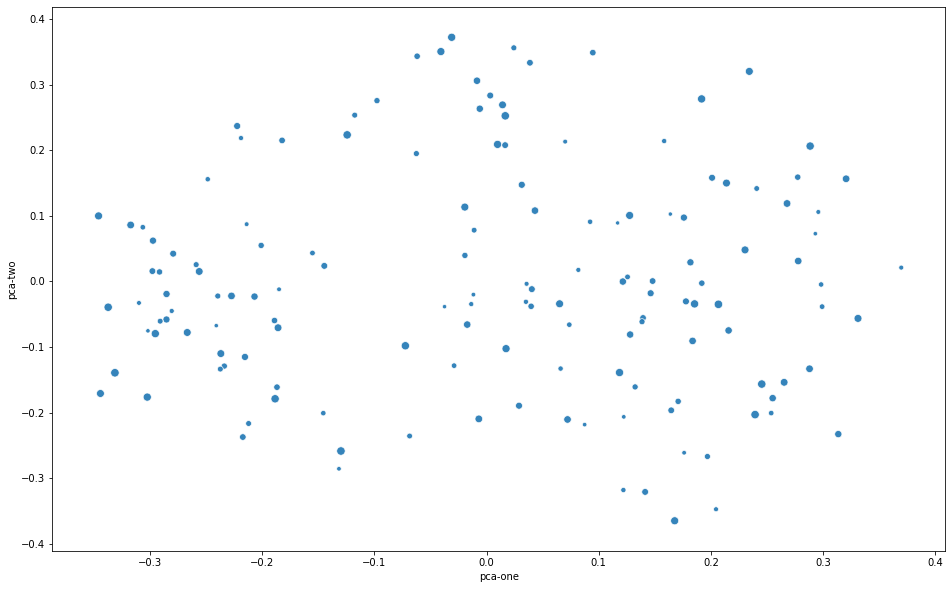

In [4]:
df = pd.DataFrame(clusters_centroids_all)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df["names"] = cluster_names
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", 
    y="pca-two",
    size="names",
    palette=sns.color_palette("muted"),
    data=df,
    legend=False,
    alpha=0.9,
    #markers="names"
)


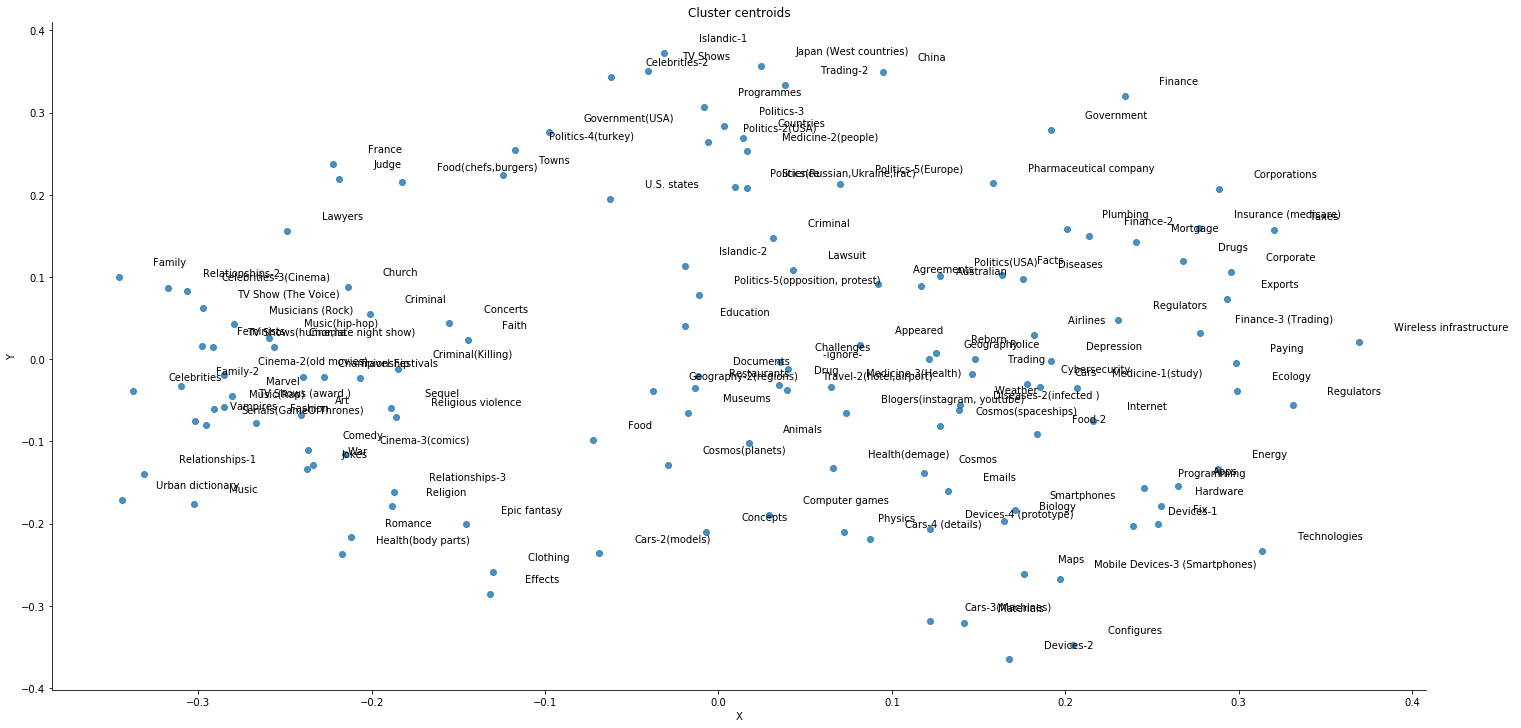

In [5]:

df = pd.DataFrame(clusters_centroids_all)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df["names"] = cluster_names
ax = sns.lmplot('pca-one', # Horizontal axis
           'pca-two', # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Cluster centroids')
# Set x-axis label
plt.xlabel('X')
# Set y-axis label
plt.ylabel('Y')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df['pca-one'], df['pca-two'], df["names"], plt.gca()) 

In [6]:
range_my = pd.date_range(datetime(2014, 3, 10), datetime(2014, 3, 11))
vecs = list()
for article in articles_input.iterator(range_my[0], range_my[-1]):
    vecs.append(VecDoc(article, embedding_model, MIN_SENTENCE_LEN))

In [7]:
norm_embeding_sentence = list()
for embedding in vecs[0].embedding_sentences():
    norm_embedding = embedding / np.linalg.norm(embedding)
    norm_embeding_sentence.append(norm_embedding)
vecs[50].article().text

"Today, the stock market opened lower on fears of global economic sluggishness, with the Dow Jones Industrials (DJINDICES:^DJI) falling 72 points as of 12:30 p.m. EDT and the S&P 500 declining from Friday's record close. Yet in light of the longer-term trends that helped the Dow's bull market reach the ripe old age of 5 yesterday, many investors are looking forward to the beginning of the first-quarter earnings season for signals about whether the blue-chip index has further to climb in the months and years ahead. Will winter ever end? The main storyline that most investors have followed closely during the first quarter is the impact of harsh winter weather on the economy. Already we've seen countless companies cite weather problems to justify sluggish results, with even major producers citing issues that could hurt first-quarter earnings. For instance, automaker Ford (NYSE:F) said last week that delays in fleet orders due to the winter weather played a sizable role in the company's ov

In [8]:
sentence_df = pd.DataFrame(norm_embeding_sentence)
sentence_df["names"] = "sentences_news"

In [9]:
df_centroids = pd.DataFrame(clusters_centroids_all)
df_centroids["names"] = cluster_names

In [10]:
def draw_cluster_with_sentence_db(sentence_df, df_centroids):
    df = df_centroids.append(sentence_df)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df.drop('names', axis=1).values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]

    ax = sns.lmplot('pca-one', # Horizontal axis
               'pca-two', # Vertical axis
               data=df, # Data source
               fit_reg=False, # Don't fix a regression line
               height = 10,
               aspect =2 ) # size and dimension

    plt.title('Cluster centroids and sentence news')
    # Set x-axis label
    plt.xlabel('X')
    # Set y-axis label
    plt.ylabel('Y')


    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))

    label_point(df['pca-one'], df['pca-two'], df["names"], plt.gca()) 

In [11]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
kk=50
topic_cos_threshold = 0.3
scale_dist = -1 # not important!
embedding2topics = Embedding2TopicsClustering(cluster_centroids_file_path,
                                              cluster_names_file_path,
                                              topic_cos_threshold,
                                              scale_dist,
                                              VOTE_MAX_NUMBER)
print(vecs[kk].article().text)
vec_topic = embedding2topics.convert(vecs[kk].embedding_sentences())
if vec_topic is not None:
    vec_embeding = list(zip(embedding2topics.convert(vecs[kk].embedding_sentences()), embedding2topics.names))
    vec_embeding.sort(key=lambda x: x[0], reverse=True)
    pp.pprint(vec_embeding)
else:
    print(vec_topic)

Today, the stock market opened lower on fears of global economic sluggishness, with the Dow Jones Industrials (DJINDICES:^DJI) falling 72 points as of 12:30 p.m. EDT and the S&P 500 declining from Friday's record close. Yet in light of the longer-term trends that helped the Dow's bull market reach the ripe old age of 5 yesterday, many investors are looking forward to the beginning of the first-quarter earnings season for signals about whether the blue-chip index has further to climb in the months and years ahead. Will winter ever end? The main storyline that most investors have followed closely during the first quarter is the impact of harsh winter weather on the economy. Already we've seen countless companies cite weather problems to justify sluggish results, with even major producers citing issues that could hurt first-quarter earnings. For instance, automaker Ford (NYSE:F) said last week that delays in fleet orders due to the winter weather played a sizable role in the company's ove

In [12]:
norm_embedding = vecs[kk].embedding_sentences()[0] / np.linalg.norm(vecs[kk].embedding_sentences()[0])
norm_embedding

array([-6.2999785e-02,  9.2519671e-02,  7.6949671e-02,  1.0846955e-01,
        9.0626352e-02,  1.2525092e-01,  8.4138021e-02,  1.5509428e-01,
        1.2966549e-01,  4.4269826e-02,  7.0369698e-02,  1.8640912e-01,
       -3.8802061e-02,  4.8494220e-02,  1.1990996e-01,  1.5747313e-01,
       -4.5246840e-02, -1.3698280e-02, -5.1148348e-02,  8.7480925e-02,
       -6.8078242e-02, -8.4455110e-02, -2.2089124e-02, -1.6194069e-01,
        1.1984810e-01, -5.2763302e-02, -3.1106848e-02,  4.0798821e-02,
        6.4097896e-02,  6.7258820e-02,  7.3401339e-02, -2.3138992e-02,
       -1.6181743e-01,  8.9925779e-03, -1.0241229e-01,  3.4881111e-02,
       -4.4763181e-02,  5.3881500e-02,  1.5581711e-01,  1.2054944e-01,
        2.0302539e-01, -1.4913023e-01,  1.2882534e-01,  2.1131372e-03,
        6.0223464e-02,  4.5401394e-02,  2.1580936e-02,  5.4909293e-02,
        1.7342214e-02,  4.2472579e-02,  1.5787470e-01, -5.0882023e-02,
        5.6225993e-02,  5.2201685e-02,  1.0152505e-02, -4.4027492e-02,
      

In [13]:
norm_embedding = norm_embedding.reshape((1, norm_embedding.shape[0]))
norm_embedding = norm_embedding.astype(np.float32) 


In [14]:
norm_embedding

array([[-6.2999785e-02,  9.2519671e-02,  7.6949671e-02,  1.0846955e-01,
         9.0626352e-02,  1.2525092e-01,  8.4138021e-02,  1.5509428e-01,
         1.2966549e-01,  4.4269826e-02,  7.0369698e-02,  1.8640912e-01,
        -3.8802061e-02,  4.8494220e-02,  1.1990996e-01,  1.5747313e-01,
        -4.5246840e-02, -1.3698280e-02, -5.1148348e-02,  8.7480925e-02,
        -6.8078242e-02, -8.4455110e-02, -2.2089124e-02, -1.6194069e-01,
         1.1984810e-01, -5.2763302e-02, -3.1106848e-02,  4.0798821e-02,
         6.4097896e-02,  6.7258820e-02,  7.3401339e-02, -2.3138992e-02,
        -1.6181743e-01,  8.9925779e-03, -1.0241229e-01,  3.4881111e-02,
        -4.4763181e-02,  5.3881500e-02,  1.5581711e-01,  1.2054944e-01,
         2.0302539e-01, -1.4913023e-01,  1.2882534e-01,  2.1131372e-03,
         6.0223464e-02,  4.5401394e-02,  2.1580936e-02,  5.4909293e-02,
         1.7342214e-02,  4.2472579e-02,  1.5787470e-01, -5.0882023e-02,
         5.6225993e-02,  5.2201685e-02,  1.0152505e-02, -4.40274

In [15]:
lims, dist, ind = embedding2topics.index.range_search(norm_embedding, topic_cos_threshold)
sentence_dict = list(zip(dist, embedding2topics.names, range(len(embedding2topics.names))))
sentence_dict.sort(key=lambda x: x[0], reverse=True)
sentence_dict

[(0.6119927, 'Trading\n', 62),
 (0.59711635, 'Finance-2\n', 28),
 (0.58330965, 'Politics-3\n', 67),
 (0.5623822, 'Mortgage \n', 106),
 (0.55049646, 'Marvel \n', 124),
 (0.5475819, 'Cars-4 (details)\n', 138),
 (0.5216116, 'Finance-3 (Trading)\n', 42),
 (0.5142305, 'Wireless infrastructure  \n', 127),
 (0.49068367, 'Travel-2(hotel,airport)\n', 84),
 (0.48684883, 'Epic fantasy\n', 114),
 (0.4855491, 'Art\n', 141),
 (0.4847328, 'Biology\n', 73),
 (0.48224014, 'Programming\n', 5),
 (0.47892356, 'Government \n', 12),
 (0.47861934, 'Corporations\n', 10),
 (0.47794616, 'Geography-2(regions)\n', 142),
 (0.47695628, 'Trading-2\n', 74),
 (0.47516826, 'Cars-2(models)\n', 104),
 (0.4739576, 'China\n', 80),
 (0.4710405, 'Documents\n', 134),
 (0.47012872, 'Taxes\n', 39),
 (0.46981654, 'Cars-3(Machines)\n', 119),
 (0.46946213, 'Lawsuit\n', 44),
 (0.46770525, 'Concepts\n', 36),
 (0.46663016, 'Celebrities-2\n', 83),
 (0.46431923, 'Regulators\n', 26),
 (0.46279418, 'Finance\n', 25),
 (0.45980024, 'Corpor

In [16]:
dist

array([0.4492785 , 0.36032254, 0.39089137, 0.36081028, 0.36177492,
       0.48224014, 0.42690456, 0.39567214, 0.4120327 , 0.3766816 ,
       0.47861934, 0.4211691 , 0.47892356, 0.33665875, 0.38203502,
       0.4115168 , 0.38568956, 0.41083807, 0.38341215, 0.45393747,
       0.3422218 , 0.3811931 , 0.31505498, 0.42806453, 0.36786577,
       0.46279418, 0.46431923, 0.3626787 , 0.59711635, 0.34511063,
       0.43268955, 0.35076135, 0.40616876, 0.3954109 , 0.37140673,
       0.38298094, 0.46770525, 0.34073815, 0.45527658, 0.47012872,
       0.44830614, 0.45393604, 0.5216116 , 0.345366  , 0.46946213,
       0.32457823, 0.4196564 , 0.41198653, 0.44863814, 0.389362  ,
       0.36564377, 0.366058  , 0.45516717, 0.3819379 , 0.3915522 ,
       0.3944659 , 0.38608095, 0.37036112, 0.3574329 , 0.41600057,
       0.38259256, 0.4184969 , 0.6119927 , 0.37132278, 0.42951995,
       0.38260603, 0.36165488, 0.58330965, 0.37221116, 0.42593974,
       0.37936565, 0.32450128, 0.34222057, 0.4847328 , 0.47695

In [17]:
sentence_df = pd.DataFrame(norm_embedding)
sentence_df["names"] = "sentences_news"
sentence_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,names
0,-0.063,0.09252,0.07695,0.10847,0.090626,0.125251,0.084138,0.155094,0.129665,0.04427,...,0.065221,0.121587,-0.143544,-0.02115,-0.153949,-0.1028,0.02525,0.182851,-0.046654,sentences_news


In [18]:
df_centroids.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,names
0,-0.030928,0.040685,0.031841,0.121731,-0.092549,0.112422,-0.010058,-0.067494,-0.031224,0.009964,...,0.067137,-0.013732,0.014118,0.089120,-0.107124,0.015677,-0.103539,0.087117,-0.017253,Relationships-1\n
1,-0.126452,0.037008,-0.178016,0.107460,0.004701,0.036442,0.096397,-0.052583,-0.085937,0.006878,...,0.067102,-0.034158,-0.053504,0.104455,-0.044276,0.047859,-0.027187,0.060603,0.009052,Medicine-1(study)\n
2,0.028515,0.068716,-0.035153,0.152958,-0.046342,-0.003914,0.046110,-0.042106,-0.038405,0.105553,...,0.080096,-0.026871,0.023998,0.112243,-0.101827,-0.008096,-0.112998,0.135752,0.057207,Clothing \n
3,0.005398,-0.038378,-0.070716,0.035322,-0.009603,0.041291,-0.053514,-0.012765,-0.020559,0.062543,...,0.017713,0.032399,-0.029071,0.003211,-0.064676,-0.098514,0.026230,0.019300,0.092358,Devices-1\n
4,-0.194091,-0.108265,-0.004629,0.095240,-0.050734,0.098733,0.122274,-0.042651,-0.072266,0.000843,...,-0.015035,-0.038820,-0.016095,0.096710,-0.060715,-0.011749,0.021659,0.092380,0.033046,Medicine-2(people)\n


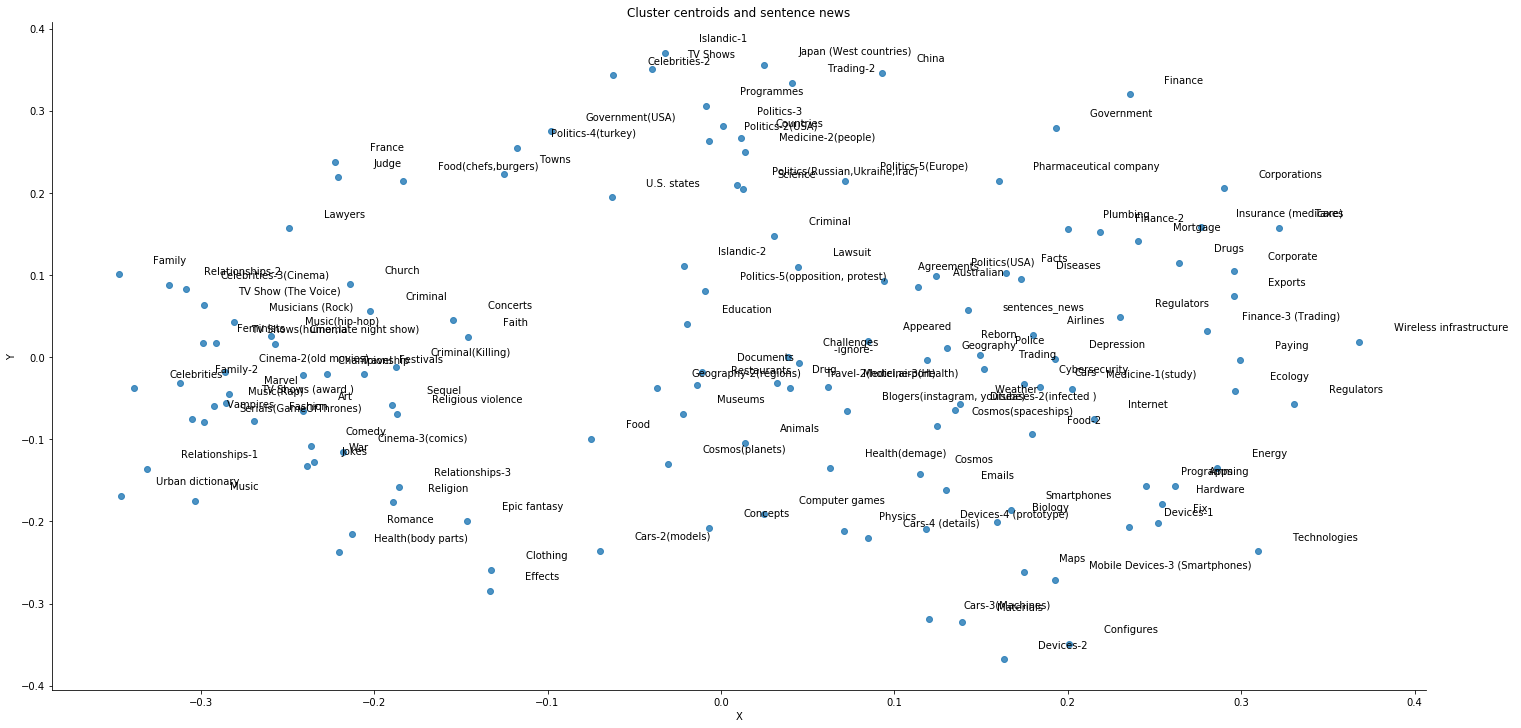

In [19]:
draw_cluster_with_sentence_db(sentence_df, df_centroids)

In [20]:
vecs[kk].article().text

"Today, the stock market opened lower on fears of global economic sluggishness, with the Dow Jones Industrials (DJINDICES:^DJI) falling 72 points as of 12:30 p.m. EDT and the S&P 500 declining from Friday's record close. Yet in light of the longer-term trends that helped the Dow's bull market reach the ripe old age of 5 yesterday, many investors are looking forward to the beginning of the first-quarter earnings season for signals about whether the blue-chip index has further to climb in the months and years ahead. Will winter ever end? The main storyline that most investors have followed closely during the first quarter is the impact of harsh winter weather on the economy. Already we've seen countless companies cite weather problems to justify sluggish results, with even major producers citing issues that could hurt first-quarter earnings. For instance, automaker Ford (NYSE:F) said last week that delays in fleet orders due to the winter weather played a sizable role in the company's ov

In [21]:
word_vec = vecs[kk].embedding_model.word2vec("economic") / np.linalg.norm(vecs[kk].embedding_model.word2vec("economic"))
word_df = pd.DataFrame(word_vec.reshape(1,100))
word_df["names"] = "!! WORD ECONOMIC !!"
word_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,names
0,-0.07604,0.02843,0.165611,-0.009905,0.182839,-0.026584,-0.059581,0.162942,-0.013918,0.022167,...,0.04512,0.038194,-0.014024,-0.08005,-0.027425,-0.084273,0.192284,0.126198,-0.140159,!! WORD ECONOMIC !!


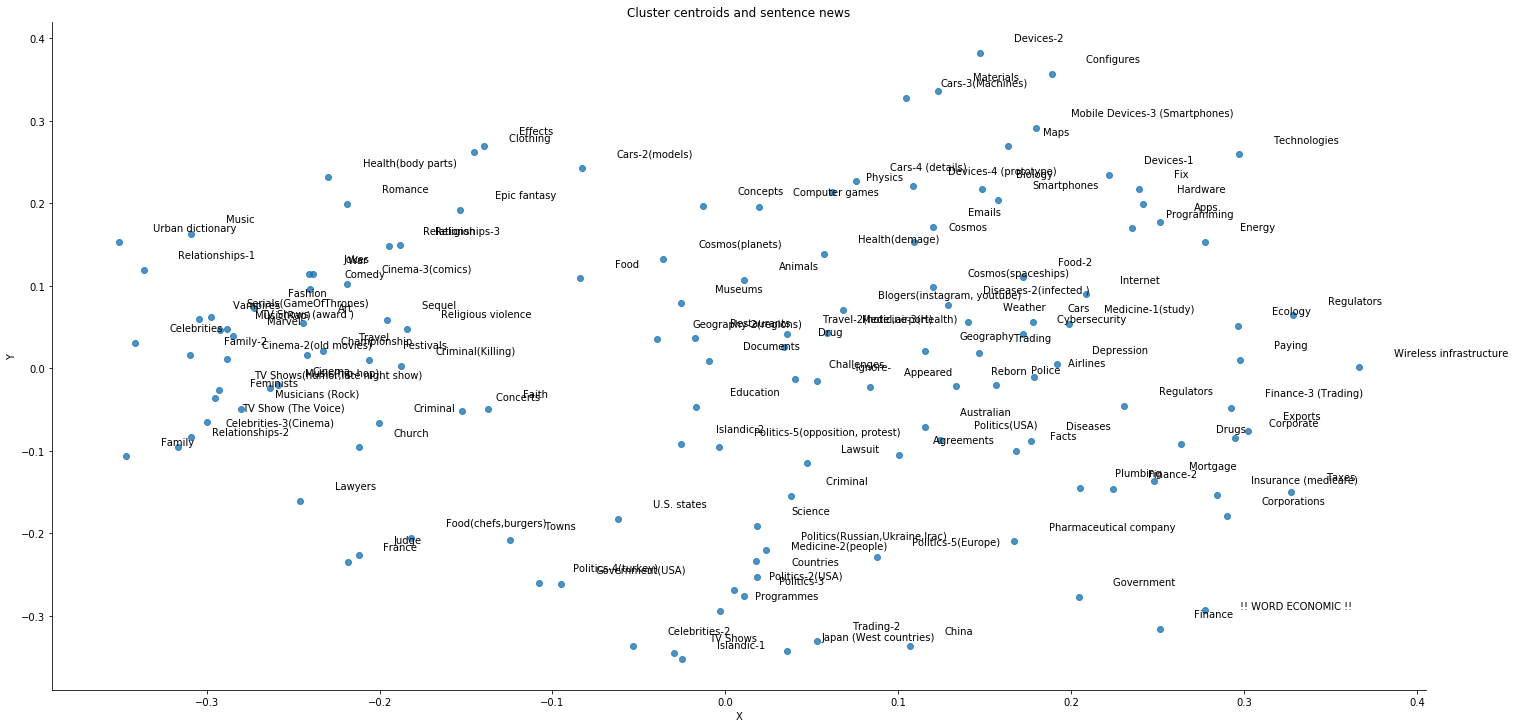

In [22]:
draw_cluster_with_sentence_db(word_df, df_centroids)